In [1]:
%matplotlib notebook
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv, lstsq

from poly_basis import *
from spherepts import *
from rbf import *

from math import *

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def L_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        r2 = dist(x,y)**2
        ret -= sigma*np.exp(-sigma*r2) * (4+r2*(-2+(-4+r2)*sigma))
    return ret
    
def sum_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        ret += np.exp(-sigma*dist(x,y)**2)
    return ret

def get_exact(harm_index):
    if harm_index is 'gaussians':
        sigmas = [2, .5, .3, .1, 5, 2, 1.5]
        ys = np.array([ [0,0,1],
                        [1,-1,1],
                        [2,0,1],
                        [-5,7,0],
                        [2,-13,1],
                        [2,12,-15],
                        [1,0,-1]], dtype=np.float)
        # project the centers onto the sphere
        for i, y in enumerate(ys):
            ys[i] = 1.0/norm(y)* y
        foo = lambda x: sum_gauss(x, sigmas, ys)
        exact = lambda x: L_gauss(x, sigmas, ys)
    else:
        # f is a spherical harmoic of degree below
        harm_index = 20

        sol_deg = sphere_harm_degs[harm_index]
        foo = lambda x: sphere_harm[harm_index](*x)
        exact = lambda x: -sol_deg*(sol_deg+1)*foo(x)
        print('Harmonic degree: %d' % sphere_harm_degs[harm_index])

    return foo, exact

In [91]:
n = 2000
k = 50
c = 100
rbf_obj = rbf_dict['gaussian']
eps = 5
foo, exact = get_exact('gaussians')
# foo, exact = get_exact(10)

nodes = gen_spiral_nodes(n)
normals = nodes
tree = cKDTree(np.array(nodes))
stencil = tree.query(nodes[c], k)[1]
nn = nodes[stencil]

<IPython.core.display.Javascript object>


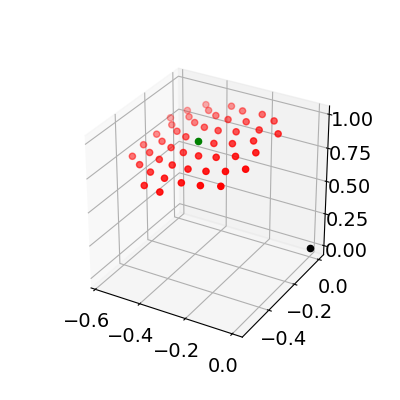

In [92]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nn[1:,0], nn[1:,1], nn[1:,2], '.', color='r')
ax.scatter(nn[0,0], nn[0,1], nn[0,2], '.', color='g')
ax.scatter(0, 0, 0, '.', color='k')

plt.show()

In [55]:
phi  = rbf_obj['rbf']
phi1 = rbf_obj['zeta']
phi2 = rbf_obj['chi']
phi3 = rbf_obj['beta']
phi4 = rbf_obj['gamma']
d2phi = rbf_obj['d2rbf']
def Gx(r, d, eps):
    return d*phi1(r,eps)
def Hx(r, d,eps):
    return phi1(r,eps) + d**2 * phi2(r,eps)
def GHx(r, d,eps):
    return 3*d*phi2(r,eps) + d**3 * phi3(r,eps)
def HHx(r, d,eps):
    return 3*phi2(r,eps) + 6 * d**2 * phi3(r,eps) + d**4 * phi4(r,eps)
def Lphi(r, eps):
    return 2*phi1(r,eps) + d2phi(r,eps)
#     return 3*phi1(r,eps) + r**2 * phi2(r,eps)
def LG(r, d,eps):
    return 5*d*phi2(r,eps) + r**2 * d * phi3(r,eps)
def LH(r,d,eps):
    return 5*phi2(r,eps) + (r**2 + 7*d**2)*phi3(r,eps) + (d*r)**2 * phi4(r,eps)

In [96]:
r = dist_outer(nn,nn)
d = (nn - nn[0]) @ nn[0]
B = np.zeros((k,k+2))

B[:,:k] = Lphi(r, eps)
B[:,-2] = LG(0, 0, eps)
B[:,-1] = LH(0, 0, eps)

A = np.zeros((k+2,k+2))
A[:k, :k] = phi(r, eps)
A[:k, -2] = Gx(r[0], d, eps)
A[-2, :k] = -A[:k, -2]
A[:k, -1] = Hx(r[0], d, eps)
A[-1, :k] = A[:k, -1]
A[-2, -2] = -Hx(0, 0, eps)
A[-2, -1] = -GHx(0, 0, eps)
A[-1, -2] = -A[-2, -1]
A[-1, -1] = HHx(0, 0, eps)

# A[:k, :k] = phi(r, eps)
# A[:k, -2] = Gx(r[0], d, eps)
# A[-2, :k] = A[:k, -2]
# A[:k, -1] = Hx(r[0], d, eps)
# A[-1, :k] = A[:k, -1]
# A[-2, -2] = Hx(0, 0, eps)
# A[-2, -1] = GHx(0, 0, eps)
# A[-1, -2] = A[-2, -1]
# A[-1, -1] = HHx(0, 0, eps)

print('cond(A) = %g' % np.log(cond(A)))
print('cond(phi(r))= %g' % np.log(cond(A[:k,:k])))

# C = (B @ la.inv(A))[:,:k]
C = la.solve(A.T, B.T).T[:,:k]

fs = np.array([foo(node) for node in nn])
ds = np.array([exact(node) for node in nn])

# fs_extended = np.zeros(k+2)
# fs_extended[:k] = fs
# us = B @ la.solve(A, fs_extended)

us = C @ fs

rel_error_L2  = la.norm(us - ds)/la.norm(ds)
print('error: %g' % rel_error_L2)

cond(A) = 16.8389
cond(phi(r))= 13.8033
error: 1.76303


In [94]:
A[:,k]

array([  0.        ,  -0.06581092,  -0.06814414,  -0.07799263,
        -0.0950759 ,  -0.10452875,  -0.11447557,  -0.14463147,
        -0.2226885 ,  -0.22586354,  -0.22599309,  -0.23530747,
        -0.2399262 ,  -0.2475905 ,  -0.26669448,  -0.28233627,
        -0.28586557,  -0.29248485,  -0.31654472,  -0.3634922 ,
        -0.36922101,  -0.36925048,  -0.39318086,  -0.41806536,
        -0.43606963,  -0.44159389,  -0.44223636,  -0.452091  ,
        -0.45244975,  -0.4652175 ,  -0.47255455,  -0.48072008,
        -0.48077341,  -0.4832759 ,  -0.51897464,  -0.51973094,
        -0.53430174,  -0.54706642,  -0.56093848,  -0.56137572,
        -0.59726953,  -0.62227351,  -0.62499956,  -0.63568879,
        -0.63617052,  -0.64500901,  -0.65033987,  -0.65668754,
        -0.65771995,  -0.65880911, -25.        ,   0.        ])

In [95]:
A[k]

array([ -0.        ,   0.06581092,   0.06814414,   0.07799263,
         0.0950759 ,   0.10452875,   0.11447557,   0.14463147,
         0.2226885 ,   0.22586354,   0.22599309,   0.23530747,
         0.2399262 ,   0.2475905 ,   0.26669448,   0.28233627,
         0.28586557,   0.29248485,   0.31654472,   0.3634922 ,
         0.36922101,   0.36925048,   0.39318086,   0.41806536,
         0.43606963,   0.44159389,   0.44223636,   0.452091  ,
         0.45244975,   0.4652175 ,   0.47255455,   0.48072008,
         0.48077341,   0.4832759 ,   0.51897464,   0.51973094,
         0.53430174,   0.54706642,   0.56093848,   0.56137572,
         0.59726953,   0.62227351,   0.62499956,   0.63568879,
         0.63617052,   0.64500901,   0.65033987,   0.65668754,
         0.65771995,   0.65880911, -25.        ,  -0.        ])

In [41]:
print(C@fs - ds)

[ 0.96709369 12.79196495 12.52899362 14.17666405  7.0455334  10.81621731
  8.18936173  9.3804871   4.98080097  0.30608212  5.12365683  7.37501092
  0.63160422  5.45695082 25.52318079 20.76510727  7.95155474 25.05837123
 22.05345793 40.77167426 62.59712465 48.6678484  74.78689436 46.57597559
 57.80152853 78.61200119 88.4025838  80.92083571 61.3811203  90.10677864]


In [64]:
phi2(0,5)*3

-1875.0

In [73]:
for r in [.05, 0, 10, 1.1, 2]:
    print(3*phi1(r,eps) + r**2 * phi2(r,eps) - Lphi(r, eps))

0.0
0.0
-1.1102230246251565e-16
0.0
0.0
